In [1]:
import numpy as np
import xarray as xr
import os
import cmocean
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cartopy.crs as ccrs
from mask_regions import mask_inland_seas, mask_poles
from make_cartopy_maps import add_global_map_subplot, add_regional_map_subplot, get_discrete_cmap
import gcsfs
from analysis import compute_sign_agreement
fs = gcsfs.GCSFileSystem() #list stores, stripp zarr from filename, load 

Open seasonal slc

In [2]:
exclude_models = ['INM-CM5-0','INM-CM4-8','GISS-E2-1-G','MIROC-ES2L'] #poorly performing models

datasets = []
for s,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    datasets_ssp = []
    
    fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/seasonal_slc/merged_memmean/') if '1x1' in k and ssp in k]
    datasets_ssp = xr.open_mfdataset(fns,combine='nested',coords='minimal',compat='override',concat_dim='season',engine='zarr')
    datasets_ssp['season']=[k.split('/')[-1].split('_')[0] for k in fns]
    datasets.append(datasets_ssp)
seasonal_slc = xr.concat(datasets,dim='experiment_id').drop_sel(source_id=exclude_models).load()

datasets = []
for s,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    datasets_ssp = []
    
    fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/seasonal_slc/merged_memmean/') if 'psmsl' in k and ssp in k]
    datasets_ssp = xr.open_mfdataset(fns,combine='nested',coords='minimal',compat='override',concat_dim='season',engine='zarr')
    datasets_ssp['season']=[k.split('/')[-1].split('_')[0] for k in fns]
    datasets.append(datasets_ssp)
seasonal_slc_tgs = xr.concat(datasets,dim='experiment_id').drop_sel(source_id=exclude_models).load()

#mask out some regions
seasonal_slc = mask_poles(mask_inland_seas(seasonal_slc)) #mask out some regions
seasonal_slc_tgs = mask_poles(mask_inland_seas(seasonal_slc_tgs))

#mask out gridded fields where less than 10 models have data
more_than_10_models = np.isfinite(seasonal_slc.zos_ibe.isel(season=0,drop=True)).sum(dim='source_id')>=10
seasonal_slc = seasonal_slc.where(more_than_10_models) #mask out where less than 10 models are ocean


/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


In [3]:
psmsl = xr.open_dataset('../month_means_1993_2022_psmsl.nc')
psmsl = mask_poles(mask_inland_seas(psmsl))
psmsl = psmsl.where(np.isfinite(psmsl.isel(month=0,drop=True)),drop=True)

seasonal_slc_tgs = seasonal_slc_tgs.sel({'id':psmsl.id}) #select only where observations are not masked out

Compute agreement in sign of deviation:

In [4]:
anoms = seasonal_slc - seasonal_slc.sel(season='annual')
anoms_tgs = seasonal_slc_tgs - seasonal_slc_tgs.sel(season='annual')

sign_agreement_range = compute_sign_agreement(anoms,'source_id',2/3)
sign_agreement_range_tgs = compute_sign_agreement(anoms_tgs,'source_id',2/3)

**Plot absolute seasonal differences in centennial SLC:**

Plot differences in ensemble medians:

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


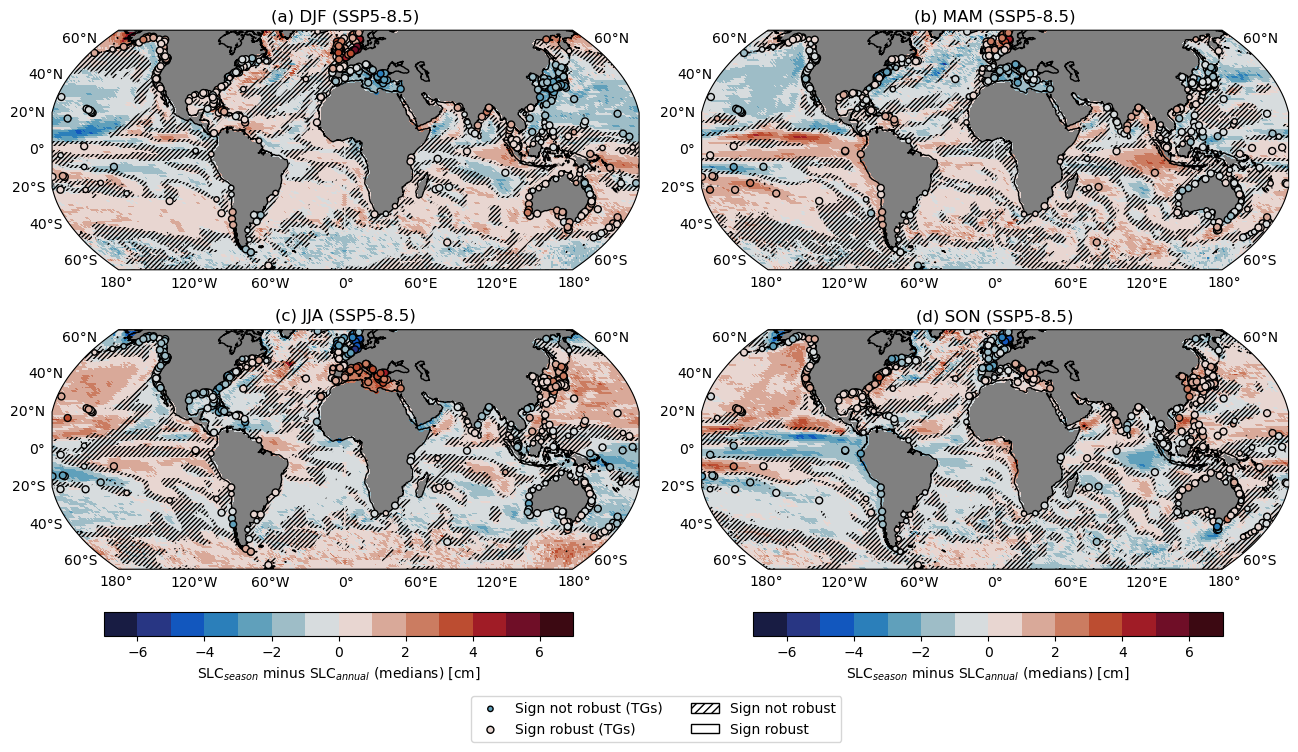

In [5]:
save_fig = 0

var = 'zos_ibe'
ssp = 'ssp585'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 14)

fig = plt.figure(figsize=(16,7))
gs = fig.add_gridspec(2,2)
gs.update(hspace=.25)
gs.update(wspace=.1)

for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean
    median_anoms = seasonal_slc.sel(season=season.lower()).median(dim='source_id') - seasonal_slc.sel(season='annual').median(dim='source_id')
    median_anom_tgs = seasonal_slc_tgs.sel(season=season.lower()).median(dim='source_id') - seasonal_slc_tgs.sel(season='annual').median(dim='source_id')

    if s<2:
        fig,ax = add_global_map_subplot(fig,median_anoms[var].sel(experiment_id=ssp),
                                     gs[np.unravel_index(s,(2,2))],-7,7,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',sign_agreement_range[var].sel(season=season).sel(experiment_id=ssp)==False,False,'')
    else:
        fig,ax = add_global_map_subplot(fig,median_anoms[var].sel(experiment_id=ssp),
                                     gs[np.unravel_index(s,(2,2))],-7,7,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',sign_agreement_range[var].sel(season=season).sel(experiment_id=ssp)==False,'below'
                                        ,'SLC$_{season}$ minus SLC$_{annual}$ (medians) [cm]')
    ax.set_facecolor("gray")
    robust_tgs = (sign_agreement_range_tgs[var].sel(season=season).sel(experiment_id=ssp)==True)
    
    s1 = ax.scatter(median_anom_tgs.lon[~robust_tgs],median_anom_tgs.lat[~robust_tgs],
                  c=median_anom_tgs[var].sel(experiment_id=ssp)[~robust_tgs],
                   vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label='Sign not robust (TGs)')
    s2 = ax.scatter(median_anom_tgs.lon[robust_tgs],median_anom_tgs.lat[robust_tgs],
                  c=median_anom_tgs[var].sel(experiment_id=ssp)[robust_tgs],
                   vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label='Sign not robust')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.05, -1, 0.3, 0.5),ncols=2)

if save_fig:
    fig.savefig('figures/seasonal_differences_'+var+'_'+ssp+'_global.png',format='png',dpi=300, bbox_inches='tight')            

Repeat for 83rd percentiles:

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


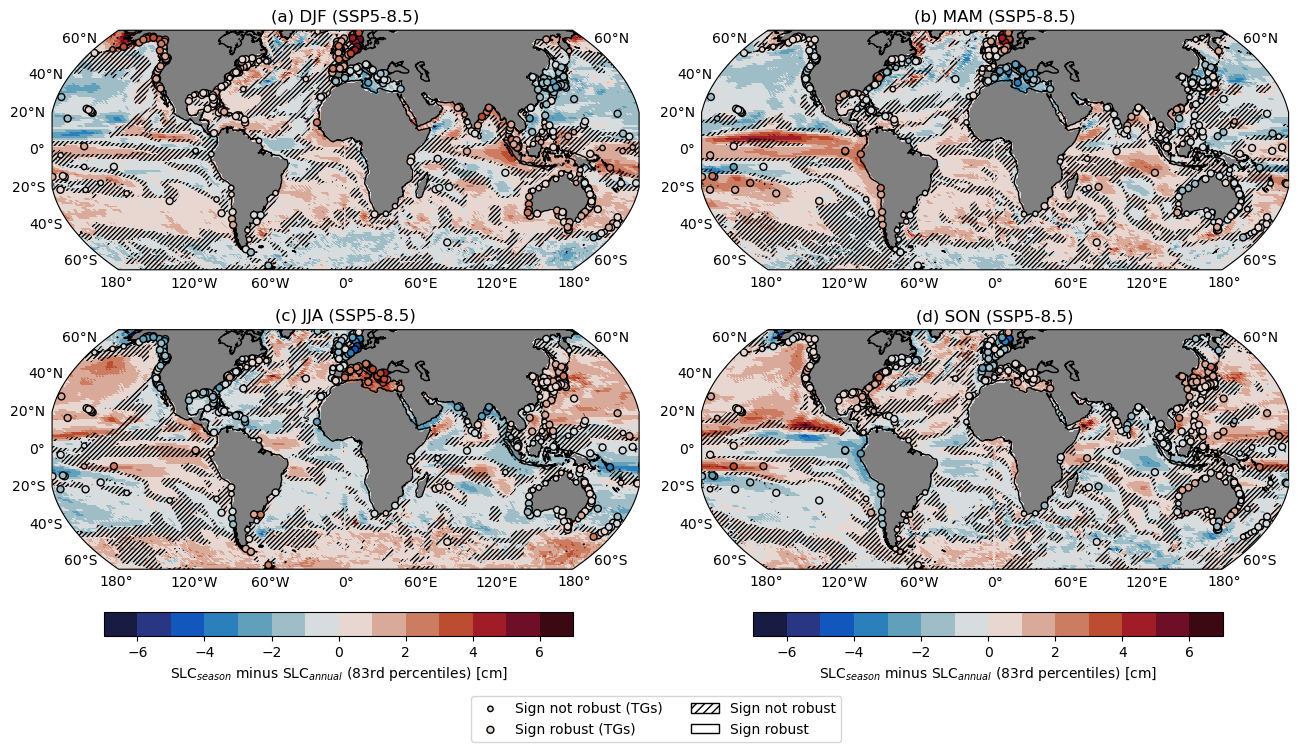

In [6]:
save_fig = 0

var = 'zos_ibe'
ssp = 'ssp585'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 14)

fig = plt.figure(figsize=(16,7))
gs = fig.add_gridspec(2,2)
gs.update(hspace=.25)
gs.update(wspace=.1)

for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean
    anoms_83rd = seasonal_slc.sel(season=season.lower()).quantile(.83,dim='source_id') - seasonal_slc.sel(season='annual').quantile(.83,dim='source_id')
    anoms_83rd_tgs = seasonal_slc_tgs.sel(season=season.lower()).quantile(.83,dim='source_id') - seasonal_slc_tgs.sel(season='annual').quantile(.83,dim='source_id')

    if s<2:
        fig,ax = add_global_map_subplot(fig,anoms_83rd[var].sel(experiment_id=ssp),
                                     gs[np.unravel_index(s,(2,2))],-7,7,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',sign_agreement_range[var].sel(season=season).sel(experiment_id=ssp)==False,False,'')
    else:
        fig,ax = add_global_map_subplot(fig,anoms_83rd[var].sel(experiment_id=ssp),
                                     gs[np.unravel_index(s,(2,2))],-7,7,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',sign_agreement_range[var].sel(season=season).sel(experiment_id=ssp)==False,'below'
                                        ,'SLC$_{season}$ minus SLC$_{annual}$ (83rd percentiles) [cm]')
    ax.set_facecolor("gray")
    robust_tgs = (sign_agreement_range_tgs[var].sel(season=season).sel(experiment_id=ssp)==True)
    
    s1 = ax.scatter(median_anom_tgs.lon[~robust_tgs],median_anom_tgs.lat[~robust_tgs],
                  c=anoms_83rd_tgs[var].sel(experiment_id=ssp)[~robust_tgs],
                   vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label='Sign not robust (TGs)')
    s2 = ax.scatter(median_anom_tgs.lon[robust_tgs],median_anom_tgs.lat[robust_tgs],
                  c=anoms_83rd_tgs[var].sel(experiment_id=ssp)[robust_tgs],
                   vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label='Sign not robust')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.05, -1, 0.3, 0.5),ncols=2)

if save_fig:
    fig.savefig('figures/seasonal_differences_'+var+'_'+ssp+'_83rd_global.png',format='png',dpi=300, bbox_inches='tight')        

Repeat for specific regions:

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


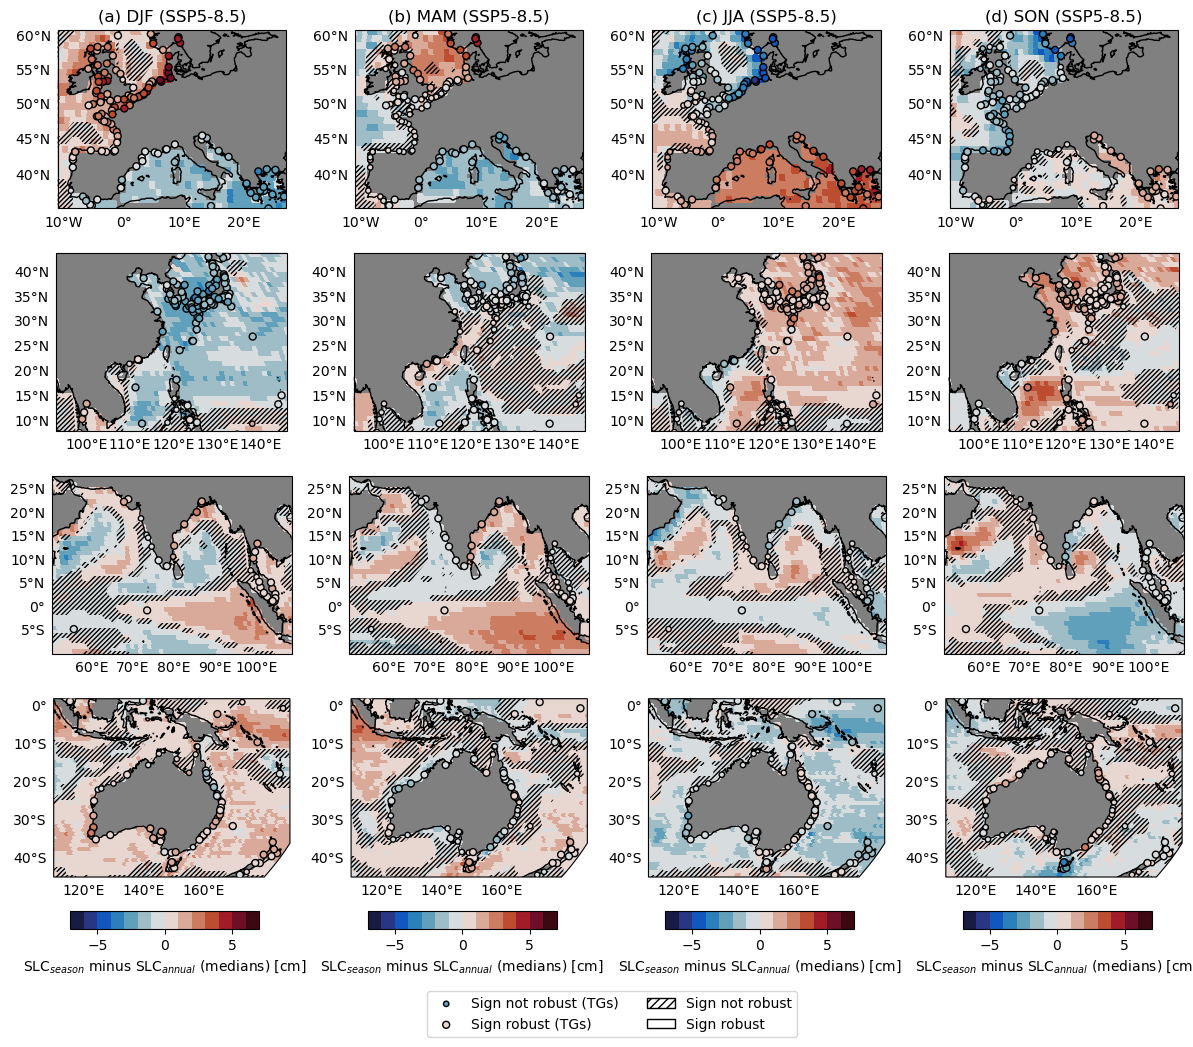

In [7]:
save_fig = 0
var = 'zos_ibe'
ssp = 'ssp585'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 14)

fig = plt.figure(figsize=(15,11))
gs = fig.add_gridspec(4,4)
gs.update(hspace=.25)
gs.update(wspace=.1)

regions = [[-11,27,35.5,61],
           [103,146,8,44],
           [52,108,-10,28],
           [110,169,-45,2]
           ]

for r,region in enumerate(regions):
    for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean

        if r==0:
            title = ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)'
        else:
            title = ''

        if r==3:
            cbar='below'
        else:
            cbar=False
        median_anoms = seasonal_slc.sel(season=season.lower()).median(dim='source_id') - seasonal_slc.sel(season='annual').median(dim='source_id')
        median_anom_tgs = seasonal_slc_tgs.sel(season=season.lower()).median(dim='source_id') - seasonal_slc_tgs.sel(season='annual').median(dim='source_id')
    
        #if s<2:
        fig,ax = add_regional_map_subplot(fig,median_anoms[var].sel(experiment_id=ssp),
                                         gs[(r,s)],region,-7,7,balance_discrete,
                                            title,sign_agreement_range[var].sel(season=season).sel(experiment_id=ssp)==False,cbar,'SLC$_{season}$ minus SLC$_{annual}$ (medians) [cm]')

        ax.set_facecolor("gray")
        robust_tgs = (sign_agreement_range_tgs[var].sel(season=season).sel(experiment_id=ssp)==True)
        
        s1 = ax.scatter(median_anom_tgs.lon[~robust_tgs],median_anom_tgs.lat[~robust_tgs],
                      c=median_anom_tgs[var].sel(experiment_id=ssp)[~robust_tgs],
                       vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label='Sign not robust (TGs)')
        s2 = ax.scatter(median_anom_tgs.lon[robust_tgs],median_anom_tgs.lat[robust_tgs],
                      c=median_anom_tgs[var].sel(experiment_id=ssp)[robust_tgs],
                       vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')


#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label='Sign not robust')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.9, -1.1, 0.3, 0.5),ncols=2)

if save_fig:
    fig.savefig('figures/seasonal_differences_'+var+'_'+ssp+'_regional.png',format='png',dpi=300, bbox_inches='tight')        

Repeat for all SSPs:

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


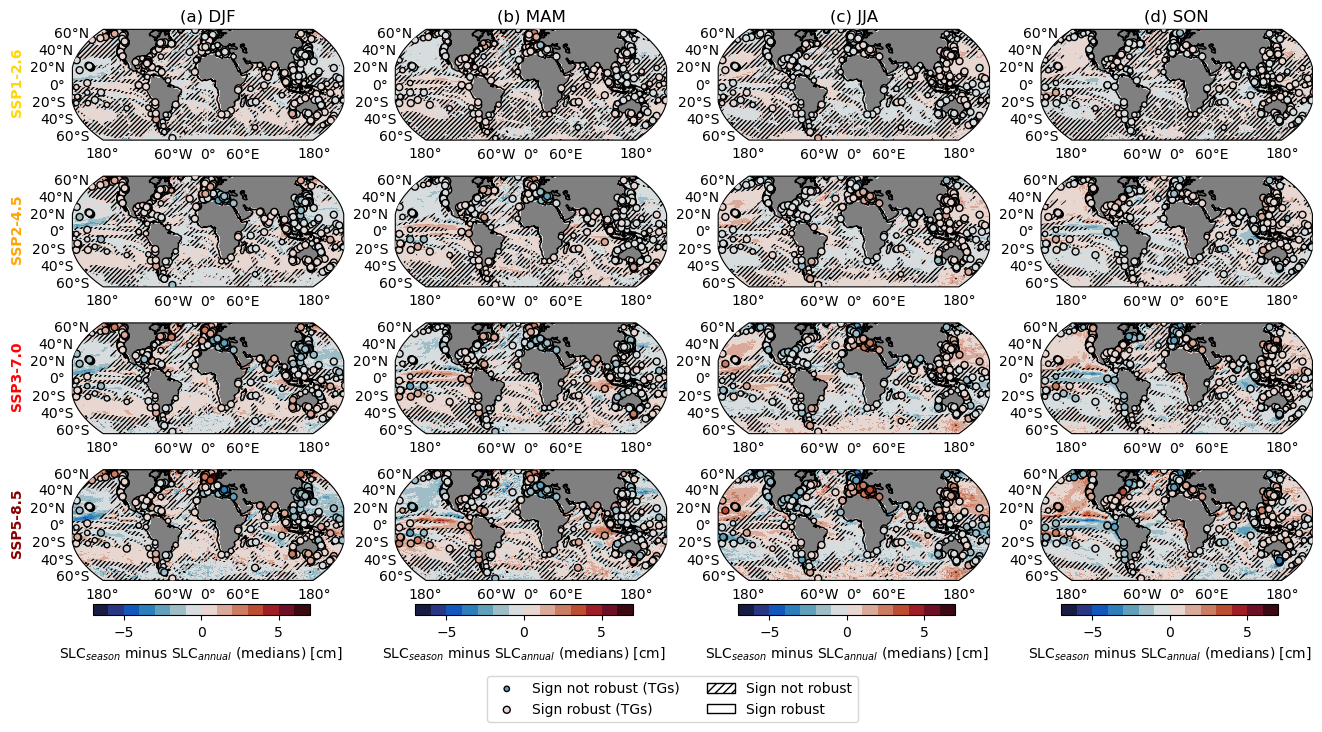

In [8]:
save_fig = 0
var = 'zos_ibe'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 14)

fig = plt.figure(figsize=(16,7.5))
gs = fig.add_gridspec(4,4)
gs.update(hspace=.07)
gs.update(wspace=.19)

for sp,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean

        if sp==0:
            title = ['(a) ','(b) ','(c) ','(d) '][s]+season.upper()
        else:
            title = ''

        if sp==3:
            cbar='below'
        else:
            cbar=False
        median_anoms = seasonal_slc.sel(season=season.lower()).median(dim='source_id') - seasonal_slc.sel(season='annual').median(dim='source_id')
        median_anom_tgs = seasonal_slc_tgs.sel(season=season.lower()).median(dim='source_id') - seasonal_slc_tgs.sel(season='annual').median(dim='source_id')
    
        #if s<2:
        fig,ax = add_global_map_subplot(fig,median_anoms[var].sel(experiment_id=ssp),
                                         gs[(sp,s)],-7,7,balance_discrete,
                                            title,sign_agreement_range[var].sel(season=season).sel(experiment_id=ssp)==False,cbar,'SLC$_{season}$ minus SLC$_{annual}$ (medians) [cm]')

        ax.set_facecolor("gray")
        robust_tgs = (sign_agreement_range_tgs[var].sel(season=season).sel(experiment_id=ssp)==True)
        
        s1 = ax.scatter(median_anom_tgs.lon[~robust_tgs],median_anom_tgs.lat[~robust_tgs],
                      c=median_anom_tgs[var].sel(experiment_id=ssp)[~robust_tgs],
                       vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label='Sign not robust (TGs)')
        s2 = ax.scatter(median_anom_tgs.lon[robust_tgs],median_anom_tgs.lat[robust_tgs],
                      c=median_anom_tgs[var].sel(experiment_id=ssp)[robust_tgs],
                       vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

        if s==0:
            ax.annotate(['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'][sp], (-.23,.24), xycoords='axes fraction',rotation=90,fontweight='bold',color=['gold','orange','red','darkred'][sp])
#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label='Sign not robust')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.95, -1.3, 0.3, 0.5),ncols=2)

if save_fig:
    fig.savefig('figures/seasonal_differences_'+var+'_all_ssps_global.png',format='png',dpi=300, bbox_inches='tight')        

Display for zos and ibe separately:

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


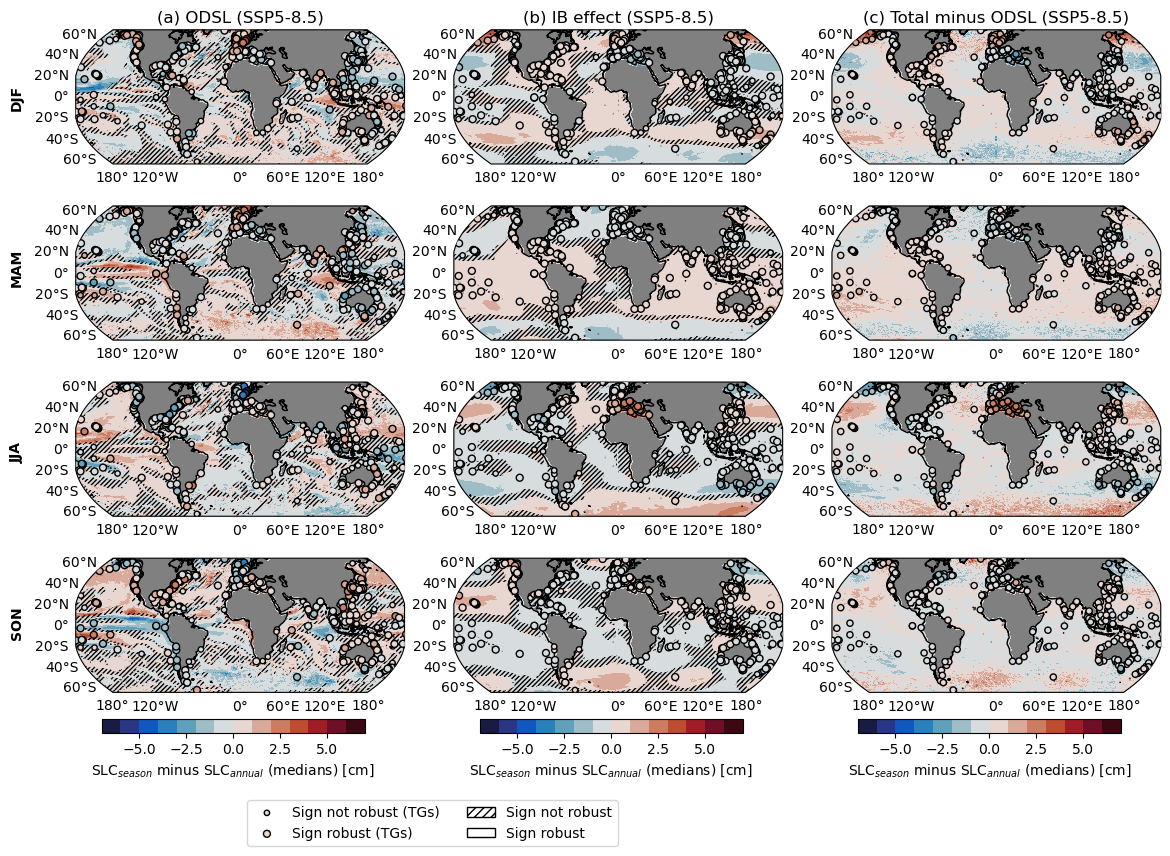

In [9]:
save_fig = 0

ssp='ssp585'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 14)

fig = plt.figure(figsize=(14,9))
gs = fig.add_gridspec(4,3)
gs.update(hspace=.07)
gs.update(wspace=.15)

for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean
    for v,var in enumerate(['zos','ibe','diff']):

        if s==0:
            title = ['(a) ODSL','(b) IB effect','(c) Total minus ODSL'][v]+' (SSP5-8.5)'
        else:
            title = ''

        if s==3:
            cbar='below'
        else:
            cbar=False
            
        median_anoms = seasonal_slc.sel(season=season.lower()).median(dim='source_id') - seasonal_slc.sel(season='annual').median(dim='source_id')
        median_anom_tgs = seasonal_slc_tgs.sel(season=season.lower()).median(dim='source_id') - seasonal_slc_tgs.sel(season='annual').median(dim='source_id')

        if v<2:
            fig,ax = add_global_map_subplot(fig,median_anoms[var].sel(experiment_id=ssp),
                                             gs[(s,v)],-7,7,balance_discrete,
                                                title,sign_agreement_range[var].sel(season=season).sel(experiment_id=ssp)==False,cbar,'SLC$_{season}$ minus SLC$_{annual}$ (medians) [cm]')
    
            ax.set_facecolor("gray")
            robust_tgs = (sign_agreement_range_tgs[var].sel(season=season).sel(experiment_id=ssp)==True)
            
            s1 = ax.scatter(median_anom_tgs.lon[~robust_tgs],median_anom_tgs.lat[~robust_tgs],
                          c=median_anom_tgs[var].sel(experiment_id=ssp)[~robust_tgs],
                           vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label='Sign not robust (TGs)')
            s2 = ax.scatter(median_anom_tgs.lon[robust_tgs],median_anom_tgs.lat[robust_tgs],
                          c=median_anom_tgs[var].sel(experiment_id=ssp)[robust_tgs],
                           vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')


            if v==1 and s==3:
                #add legend
                import matplotlib.patches as mpatches
                hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label='Sign not robust')
                no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
                ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(.22, -1.25, 0.3, 0.5),ncols=2)
        else:
            fig,ax = add_global_map_subplot(fig,median_anoms['zos_ibe'].sel(experiment_id=ssp)-median_anoms['zos'].sel(experiment_id=ssp),
                                             gs[(s,v)],-7,7,balance_discrete,
                                                title,None,cbar,'SLC$_{season}$ minus SLC$_{annual}$ (medians) [cm]')
    
            ax.set_facecolor("gray")
           
            ax.scatter(median_anom_tgs.lon,median_anom_tgs.lat,
                          c=median_anom_tgs['zos_ibe'].sel(experiment_id=ssp)-median_anom_tgs['zos'].sel(experiment_id=ssp),
                           vmin=-7,vmax=7,cmap=balance_discrete,edgecolor='black',s=20,transform=ccrs.PlateCarree(),zorder=5)
           
        if v==0:
            ax.annotate(['DJF','MAM','JJA','SON'][s], (-.2,.42), xycoords='axes fraction',fontweight='bold',rotation=90,color='black')

if save_fig:
    fig.savefig('figures/seasonal_differences_zos_vs_ibe_ssp585_global.jpg',format='jpg',dpi=300, bbox_inches='tight')      
    fig.savefig('figures/seasonal_differences_zos_vs_ibe_ssp585_global.png',format='png',dpi=300, bbox_inches='tight')        

**Repeat above for differences as fraction of the AR6 projections:**

In [5]:
fns = [os.path.join('../ar6_projections/regridded/',k) for k in os.listdir('../ar6_projections/regridded/') if '1x1' in k and 'total' in k]
ar6_total = xr.open_mfdataset(fns,combine='nested',concat_dim='experiment_id').sea_level_change/10
ar6_total['experiment_id'] = [k.split('/')[-1].split('_')[1] for k in fns]
ar6_total = (ar6_total.sel(years=2080) + ar6_total.sel(years=2090))/2

fns = [os.path.join('../ar6_projections/regridded/',k) for k in os.listdir('../ar6_projections/regridded/') if '1x1' in k and 'land' in k]
ar6_lws = xr.open_mfdataset(fns,combine='nested',concat_dim='experiment_id').sea_level_change/10
ar6_lws['experiment_id'] = [k.split('/')[-1].split('_')[1] for k in fns]
ar6_lws = (ar6_lws.sel(years=2080) + ar6_lws.sel(years=2090))/2

fns = [os.path.join('../ar6_projections/regridded/',k) for k in os.listdir('../ar6_projections/regridded/') if 'psmsl' in k and 'total' in k]
ar6_total_tgs = xr.open_mfdataset(fns,combine='nested',concat_dim='experiment_id').sel({'id':psmsl.id}).sea_level_change/10
ar6_total_tgs['experiment_id'] = [k.split('/')[-1].split('_')[1] for k in fns]
ar6_total_tgs = (ar6_total_tgs.sel(years=2080) + ar6_total_tgs.sel(years=2090))/2

fns = [os.path.join('../ar6_projections/regridded/',k) for k in os.listdir('../ar6_projections/regridded/') if 'psmsl' in k and 'land' in k]
ar6_lws_tgs = xr.open_mfdataset(fns,combine='nested',concat_dim='experiment_id').sel({'id':psmsl.id}).sea_level_change/10
ar6_lws_tgs['experiment_id'] = [k.split('/')[-1].split('_')[1] for k in fns]
ar6_lws_tgs = (ar6_lws_tgs.sel(years=2080) + ar6_lws_tgs.sel(years=2090))/2

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


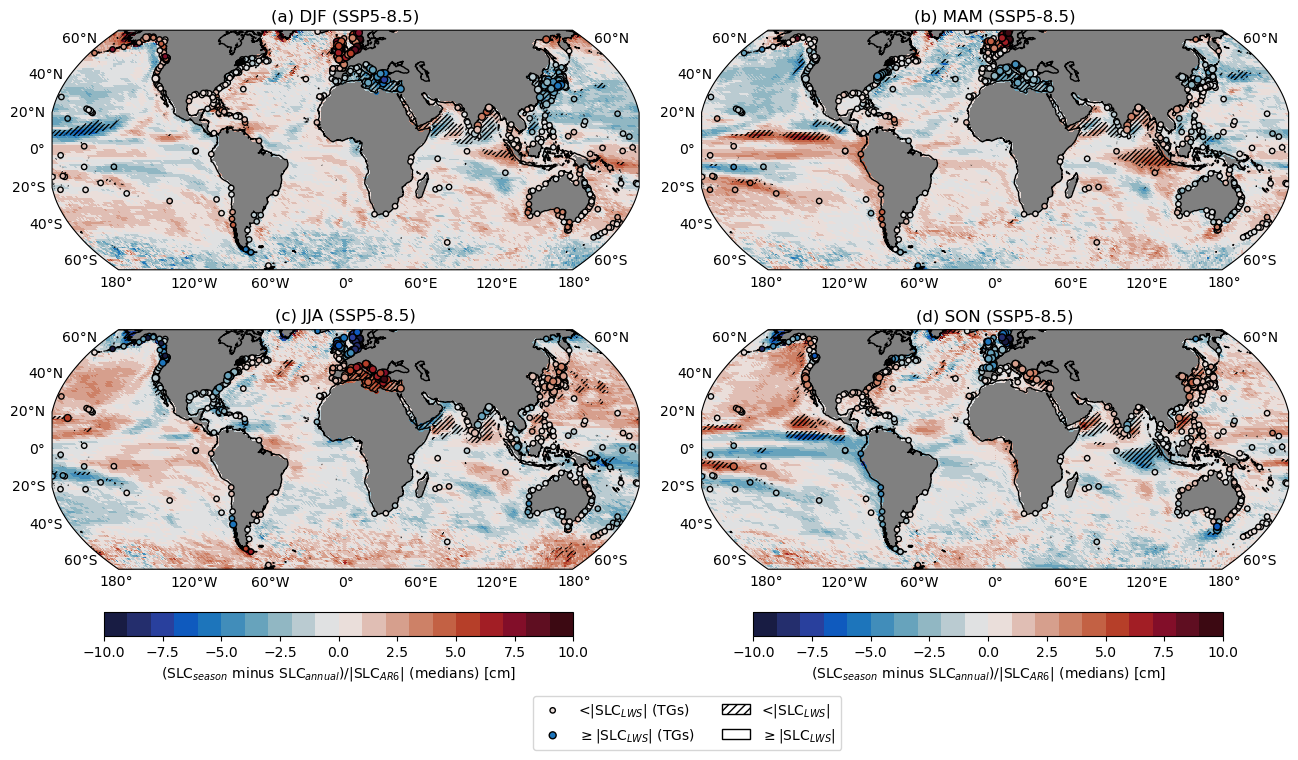

In [6]:
save_fig=1
var = 'zos_ibe'
ssp = 'ssp585'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 20)

fig = plt.figure(figsize=(16,7))
gs = fig.add_gridspec(2,2)
gs.update(hspace=.25)
gs.update(wspace=.1)

for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean
    median_anoms = seasonal_slc.sel(season=season.lower()).median(dim='source_id') - seasonal_slc.sel(season='annual').median(dim='source_id')
    median_anoms_tgs = seasonal_slc_tgs.sel(season=season.lower()).median(dim='source_id') - seasonal_slc_tgs.sel(season='annual').median(dim='source_id')

    if s<2:
        fig,ax = add_global_map_subplot(fig,100*median_anoms[var].sel(experiment_id=ssp)/np.abs(ar6_total.sel(quantiles=.5).sel(experiment_id='ssp585')),
                                     gs[np.unravel_index(s,(2,2))],-10,10,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',np.abs(median_anoms[var].sel(experiment_id=ssp))>=np.abs(ar6_lws.sel(quantiles=.5).sel(experiment_id='ssp585')),False,'')
    else:
        fig,ax = add_global_map_subplot(fig,100*median_anoms[var].sel(experiment_id=ssp)/np.abs(ar6_total.sel(quantiles=.5).sel(experiment_id='ssp585')),
                                     gs[np.unravel_index(s,(2,2))],-10,10,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',np.abs(median_anoms[var].sel(experiment_id=ssp))>=np.abs(ar6_lws.sel(quantiles=.5).sel(experiment_id='ssp585')),'below'
                                        ,'(SLC$_{season}$ minus SLC$_{annual}$)/|SLC$_{AR6}$| (medians) [cm]')
    ax.set_facecolor("gray")
    
    robust_tgs = np.abs(median_anoms_tgs[var].sel(experiment_id=ssp))>=np.abs(ar6_lws_tgs.sel(quantiles=.5).sel(experiment_id='ssp585')).values
    
    s1 = ax.scatter(median_anoms_tgs.lon[~robust_tgs],median_anoms_tgs.lat[~robust_tgs],
                  c=100*median_anoms_tgs[var].sel(experiment_id=ssp)/np.abs(ar6_total_tgs.sel(quantiles=.5).sel(experiment_id='ssp585'))[~robust_tgs],
                   vmin=-10,vmax=10,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label=r'<|SLC$_{LWS}$| (TGs)')
    s2 = ax.scatter(median_anoms_tgs.lon[robust_tgs],median_anoms_tgs.lat[robust_tgs],
                  c=100*median_anoms_tgs[var].sel(experiment_id=ssp)/np.abs(ar6_total_tgs.sel(quantiles=.5).sel(experiment_id='ssp585'))[robust_tgs],
                   vmin=-10,vmax=10,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label=r'$\geq$|SLC$_{LWS}$| (TGs)')
    
#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label=r'<|SLC$_{LWS}$|')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label=r'$\geq$|SLC$_{LWS}$|')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.05, -1, 0.3, 0.5),ncols=2)

if save_fig:
    fig.savefig('figures/seasonal_differences_'+var+'_'+ssp+'_global_relative_to_ar6.png',format='png',dpi=300, bbox_inches='tight')        


NameError: name 'var_to_plot' is not defined

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


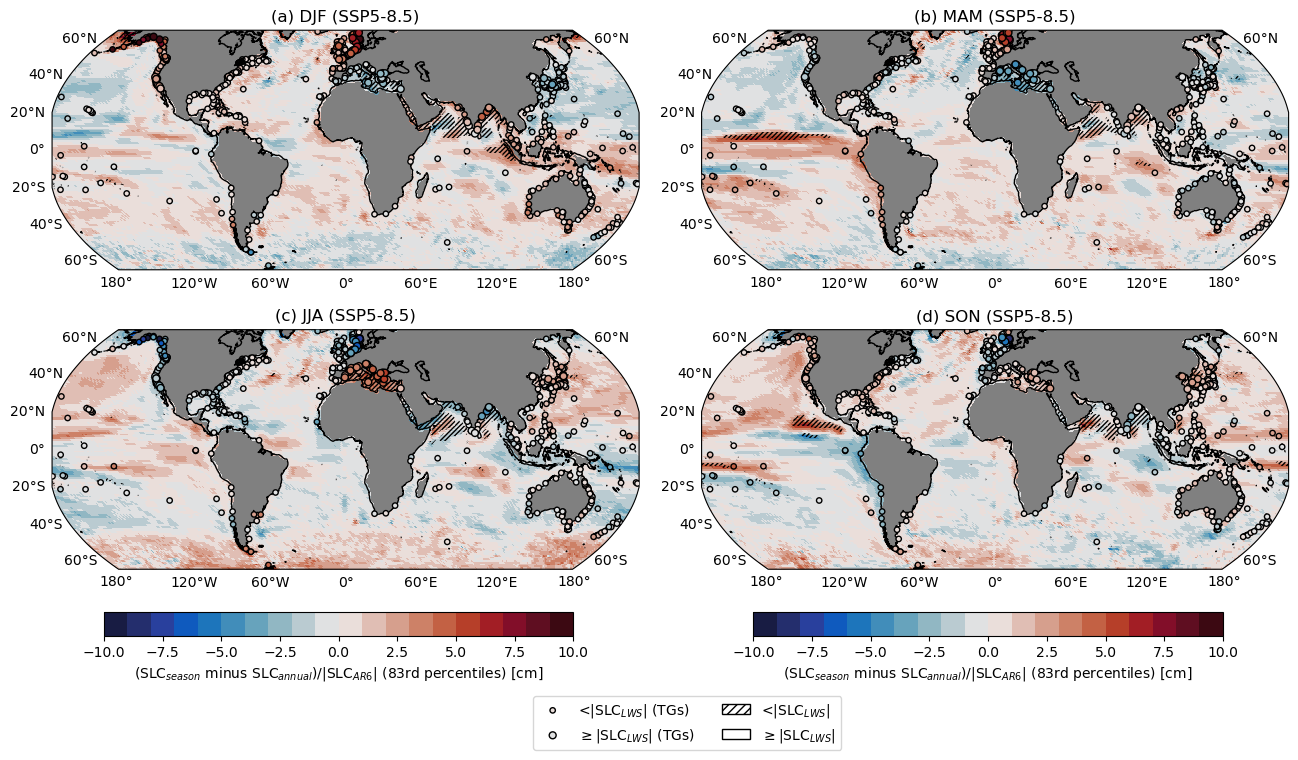

In [7]:
save_fig = 0
var = 'zos_ibe'
ssp = 'ssp585'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 20)

fig = plt.figure(figsize=(16,7))
gs = fig.add_gridspec(2,2)
gs.update(hspace=.25)
gs.update(wspace=.1)

for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean
    anoms_83rd = seasonal_slc.sel(season=season.lower()).quantile(.83,dim='source_id') - seasonal_slc.sel(season='annual').quantile(.83,dim='source_id')
    anoms_83rd_tgs = seasonal_slc_tgs.sel(season=season.lower()).quantile(.83,dim='source_id') - seasonal_slc_tgs.sel(season='annual').quantile(.83,dim='source_id')

    if s<2:
        fig,ax = add_global_map_subplot(fig,100*anoms_83rd[var].sel(experiment_id=ssp)/np.abs(ar6_total.sel(quantiles=.83).sel(experiment_id='ssp585')),
                                     gs[np.unravel_index(s,(2,2))],-10,10,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',np.abs(anoms_83rd[var].sel(experiment_id=ssp))>np.abs(ar6_lws.sel(quantiles=.83).sel(experiment_id='ssp585')),False,'')
    else:
        fig,ax = add_global_map_subplot(fig,100*anoms_83rd[var].sel(experiment_id=ssp)/np.abs(ar6_total.sel(quantiles=.83).sel(experiment_id='ssp585')),
                                     gs[np.unravel_index(s,(2,2))],-10,10,balance_discrete,
                                        ['(a) ','(b) ','(c) ','(d) '][s]+season.upper() +' (SSP5-8.5)',np.abs(anoms_83rd[var].sel(experiment_id=ssp))>np.abs(ar6_lws.sel(quantiles=.83).sel(experiment_id='ssp585')),'below'
                                        ,'(SLC$_{season}$ minus SLC$_{annual}$)/|SLC$_{AR6}$| (83rd percentiles) [cm]')
    ax.set_facecolor("gray")
    
    robust_tgs = np.abs(anoms_83rd_tgs[var].sel(experiment_id=ssp))>np.abs(ar6_lws_tgs.sel(quantiles=.83).sel(experiment_id='ssp585')).values
    
    s1 = ax.scatter(anoms_83rd_tgs.lon[~robust_tgs],anoms_83rd_tgs.lat[~robust_tgs],
                  c=100*anoms_83rd_tgs[var].sel(experiment_id=ssp)/np.abs(ar6_total_tgs.sel(quantiles=.83).sel(experiment_id='ssp585'))[~robust_tgs],
                   vmin=-10,vmax=10,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label=r'<|SLC$_{LWS}$| (TGs)')
    s2 = ax.scatter(anoms_83rd_tgs.lon[robust_tgs],anoms_83rd_tgs.lat[robust_tgs],
                  c=100*anoms_83rd_tgs[var].sel(experiment_id=ssp)/np.abs(ar6_total_tgs.sel(quantiles=.83).sel(experiment_id='ssp585'))[robust_tgs],
                   vmin=-10,vmax=10,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label=r'$\geq$|SLC$_{LWS}$| (TGs)')
    
#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label=r'<|SLC$_{LWS}$|')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label=r'$\geq$|SLC$_{LWS}$|')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.05, -1, 0.3, 0.5),ncols=2)

if save_fig:
    fig.savefig('figures/seasonal_change_dev_'+var+'_'+ssp+'_global.png',format='png',dpi=300, bbox_inches='tight')        


/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


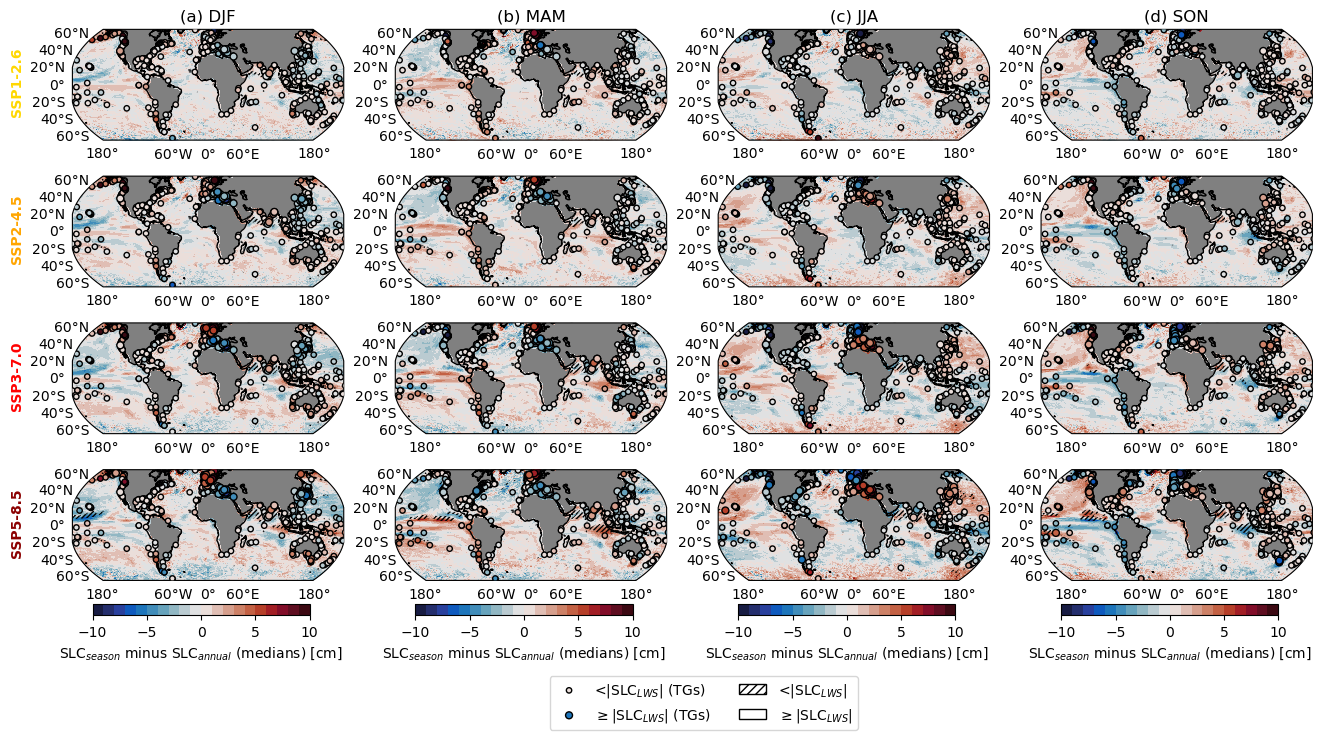

In [8]:
save_fig=1

var = 'zos_ibe'
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 20)

fig = plt.figure(figsize=(16,7.5))
gs = fig.add_gridspec(4,4)
gs.update(hspace=.07)
gs.update(wspace=.19)

for sp,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    for s,season in enumerate(['djf','mam','jja','son']): #plot ensemble mean

        if sp==0:
            title = ['(a) ','(b) ','(c) ','(d) '][s]+season.upper()
        else:
            title = ''

        if sp==3:
            cbar='below'
        else:
            cbar=False
        median_anoms = seasonal_slc.sel(season=season.lower()).median(dim='source_id') - seasonal_slc.sel(season='annual').median(dim='source_id')
        median_anoms_tgs = seasonal_slc_tgs.sel(season=season.lower()).median(dim='source_id') - seasonal_slc_tgs.sel(season='annual').median(dim='source_id')
    
        #if s<2:
        fig,ax = add_global_map_subplot(fig,100*median_anoms[var].sel(experiment_id=ssp)/np.abs(ar6_total.sel(quantiles=.5).sel(experiment_id=ssp)),
                                     gs[sp,s],-10,10,balance_discrete,
                                        title,np.abs(median_anoms[var].sel(experiment_id=ssp))>=np.abs(ar6_lws.sel(quantiles=.5).sel(experiment_id=ssp)),cbar,'SLC$_{season}$ minus SLC$_{annual}$ (medians) [cm]')

        ax.set_facecolor("gray")
        robust_tgs = np.abs(median_anoms_tgs[var].sel(experiment_id=ssp))>=np.abs(ar6_lws_tgs.sel(quantiles=.5).sel(experiment_id=ssp)).values
    
        s1 = ax.scatter(median_anoms_tgs.lon[~robust_tgs],median_anoms_tgs.lat[~robust_tgs],
                      c=100*median_anoms_tgs[var].sel(experiment_id=ssp)/np.abs(ar6_total_tgs.sel(quantiles=.5).sel(experiment_id=ssp))[~robust_tgs],
                       vmin=-10,vmax=10,cmap=balance_discrete,edgecolor='black',s=15,transform=ccrs.PlateCarree(),zorder=5, label=r'<|SLC$_{LWS}$| (TGs)')
        s2 = ax.scatter(median_anoms_tgs.lon[robust_tgs],median_anoms_tgs.lat[robust_tgs],
                      c=100*median_anoms_tgs[var].sel(experiment_id=ssp)/np.abs(ar6_total_tgs.sel(quantiles=.5).sel(experiment_id=ssp))[robust_tgs],
                   vmin=-10,vmax=10,cmap=balance_discrete,edgecolor='black',s=25,transform=ccrs.PlateCarree(),zorder=5,label=r'$\geq$|SLC$_{LWS}$| (TGs)')
    
        if s==0:
            ax.annotate(['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'][sp], (-.23,.24), xycoords='axes fraction',rotation=90,fontweight='bold',color=['gold','orange','red','darkred'][sp])
#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label=r'<|SLC$_{LWS}$|')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label=r'$\geq$|SLC$_{LWS}$|')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.95, -1.3, 0.3, 0.5),ncols=2)

if save_fig:
    fig.savefig('figures/seasonal_differences_'+var+'_'+ssp+'_global_relative_to_ar6_all_ssps.png',format='png',dpi=300, bbox_inches='tight')        
     